# Causal Lasso

This notebook provides a quick code demo for "A Bregman Method for Structure Learning on Sparse Directed Acyclic Graphs"

In [679]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from graph_tools.data_gen import gen_graph, sample_lin_scms
from causal_lasso.solver import CLSolver
from graph_tools.metrics import compare_graphs

In [680]:
import graph_tools
graph_tools.__file__

'/Users/manonromain/Documents/Bregman_DAG/graph_tools/__init__.py'

### Synthetic graph generation 

We generate a synthetic graph $G$ (here a Scale-Free graph with 50 nodes). 

In [793]:
graph_type = "scale-free" # choose between "scale-free" and "erdos-renyi"
n = 100 # number of nodes
degree_poly = 5
G, adj_matrix = gen_graph(graph_type, n, mean_deg=5)

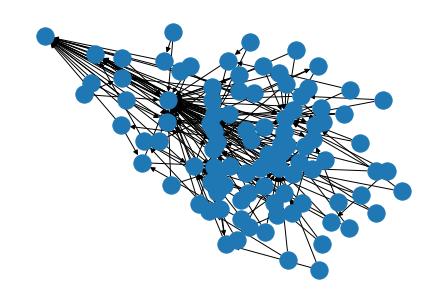

In [794]:
nx.draw(G)

### Synthetic data generation

We sample a weighted adjacency matrix `w_opt` and $m=1000$ i.i.d. samples distributed according to the SCM:

$$X = XW^* + E$$

where $X\in\mathbb{R}^{m\times n}$ is the sample matrix, $W^*\in\mathbb{R}^{n\times n}$ is the adjacency matrix of graph $G$ and $E \sim^{\text{i.i.d.}} \exp(1)$ (resp. $\mathcal{N}(0, 1)$ or $\mathrm{Gumbel}(0, 1)$)

In [815]:
noise_type = "gaussian" # or "gumbel" or "exp"
nb_samples = 1000
X, w_opt, _ = sample_lin_scms(graph_type, noise_type, adj_matrix, nb_samples=nb_samples, weighted=False)

## Learning

In [817]:
import importlib
import causal_lasso.solver as solver
from types import ModuleType

def rreload(module, d=1):
    """Recursively reload modules."""
    if d:
        for attribute_name in dir(module):
            attribute = getattr(module, attribute_name)
            if type(attribute) is ModuleType:
                rreload(attribute, d=d-1)
    print("Reloading", module)
    importlib.reload(module)
            
rreload(solver, d=1)
CLSolver = solver.CLSolver

Reloading <module 'causal_lasso.general_weights_algo' from '/Users/manonromain/Documents/Bregman_DAG/causal_lasso/general_weights_algo.py'>
Reloading <module 'numpy' from '/Users/manonromain/miniconda3/lib/python3.8/site-packages/numpy/__init__.py'>
Reloading <module 'causal_lasso.positive_weights_algo' from '/Users/manonromain/Documents/Bregman_DAG/causal_lasso/positive_weights_algo.py'>
Reloading <module 'torch' from '/Users/manonromain/miniconda3/lib/python3.8/site-packages/torch/__init__.py'>
Reloading <module 'causal_lasso.solver' from '/Users/manonromain/Documents/Bregman_DAG/causal_lasso/solver.py'>


We now use our algorithm to recover the weighted adjacency matrix from $X$.

In [818]:
# import cProfile
# cp = cProfile.Profile()
# cp.enable()
l1_pen_list =  [0, 1e-8, 1e-6, 1e-4, 1e-2, 1, 1e2, 1e4]
#for l1_pen in l1_pen_list:
algs, sols, results = {}, {}, {}

In [820]:
import mosek.fusion as msk
for version in ["init_progdag_normed"]:#, "random_progdag_normed",\
              # "init_progdag_unnorm", "random_progdag_unnorm"]:
    init_without_dag = version.startswith("init")
    X_ = X
    if version.endswith("normed"):
        X_ -= np.mean(X, axis=0, keepdims=True)
    s = np.random.randint(10)
    np.random.seed(s)
    alg = CLSolver(version="gen", dagness_exp=0.006, dagness_pen=1e-4, 
                   l1_pen=1e-2, eps=0, max_iter=100,
                   logging=True, solver="mosek", 
                   init_without_dag=init_without_dag)

    Wk = alg.fit(X_, degree_poly=degree_poly)
    _, _, _, _, shd = compare_graphs(adj_matrix, np.abs(Wk)>=0.5)
    algs[version] = alg
    sols[version] = Wk
    results[version] = shd
    

AssertionError: 

In [ ]:
results

In [ ]:
# plt.plot(l1_pen_list, results, label="ours$^{+}$")
# plt.plot(l1_pen_list, results_notears, label="notears")
# plt.xscale("log")
# plt.yscale("log")
# plt.legend()

In [ ]:
compare_graphs(adj_matrix, np.abs(Wk)>=0.5)
#results.append(shd)

In [ ]:
W_thres = np.abs(Wk)>=0.5
sns.heatmap(W_thres+w_opt)
plt.xticks([]); plt.yticks([]);
for i in range(1, n+1):
    cycles = np.trace(np.linalg.matrix_power(W_thres, i))
    if cycles:
        print("Cycle of size", i, cycles)

#### NOTEARS

To run NOTEARS, download the repository from https://github.com/xunzheng/notears in the same folder as this notebook. 

In [749]:
# Importing no tears if in parent folder
try:
    import os,sys,inspect
    currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
    parentdir = os.path.dirname(currentdir)
    sys.path.insert(0,parentdir) 

    from notears.notears.linear import notears_linear
    run_notears = True
except ImportError:
    run_notears = False

In [750]:
if run_notears:
    results_notears = []
    W_notears, log_dict_notears = notears_linear(X, 1e-1, "l2")
    _, _, _, _, shd = compare_graphs(adj_matrix, np.abs(W_notears))
    results_notears.append(shd)



Number of edges in ground truth graph 97.0
Number of edges in estimation 96
Correct edges 96.0
Reversed edges 0.0
Missing edges 1.0
Extra edges 0.0
SHD 1.0


In [724]:
import cdt
print(cdt.metrics.SHD(adj_matrix, np.abs(W_notears)>0))
print(cdt.metrics.SHD(adj_matrix, np.abs(Wk)>0))

106.0
113.0


In [725]:
_, _, _, _, shd = compare_graphs(adj_matrix, np.abs(W_notears))

Number of edges in ground truth graph 97.0
Number of edges in estimation 129
Correct edges 60.0
Reversed edges 2.0
Missing edges 35.0
Extra edges 67.0
SHD 104.0


## Extra visualisations

We provide extra visualisations that could be of interest to the reader. The first one shows convergence of different part of the objective with iteration of our algorithm. 

In [726]:
logging = alg.log_dict
log_dict_notears = {k:np.array(v) for k,v in log_dict_notears.items()}

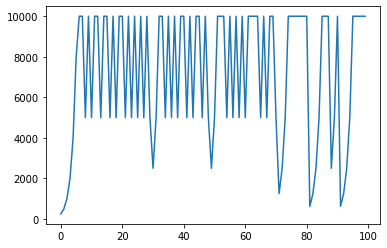

In [727]:
plt.plot(logging["gammas"])

Legend does not support [<matplotlib.lines.Line2D object at 0x7fd71949a880>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


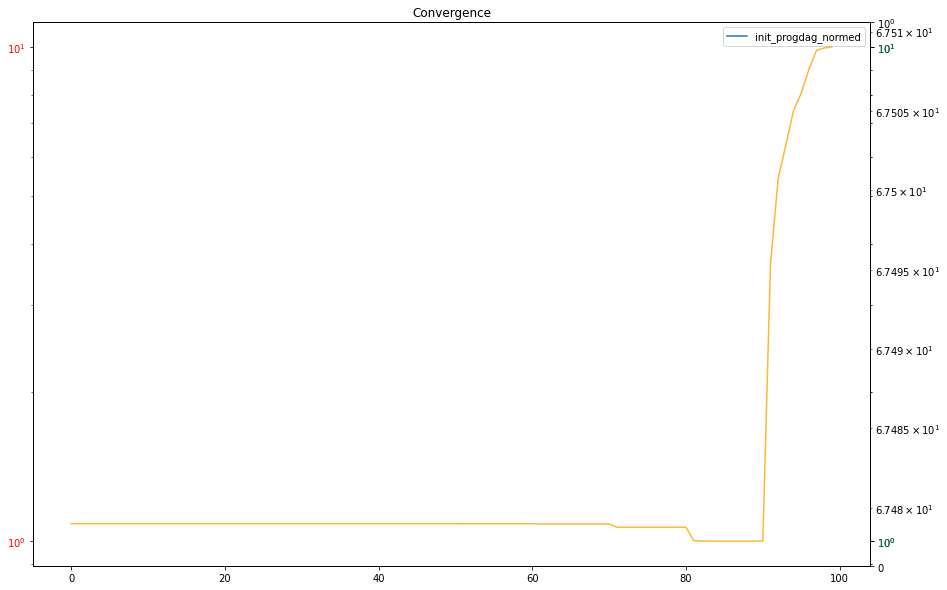

In [753]:
dict_to_plot = {v:alg.log_dict for v, alg in algs.items() if "progdag" in v}
sols_to_plot = {v:alg.sol for v, alg in algs.items() if "progdag" in v}

from matplotlib.lines import Line2D


def plot_dict(dict_to_plot, sols_to_plot):
    metrics = ["obj"]
    linestyles = ['solid', 'dotted', 'dashed', 'dashdot', 
                  (0, (3, 5, 1, 5)),(0, (3, 1, 1, 1)),(0, (3, 5, 1, 5, 1, 5)),
                 (0, (5, 10)),(0, (5, 1))]
    colors = ["red", "blue", "green", "orange", "black"]
    hlines = False
    fig, ax1 = plt.subplots(figsize=(15,10))
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()
    ax4 = ax1.twinx()
    ax5 = ax1.twinx()
    lgd_lines, lgd_labels = [], []
    for k, version in enumerate(dict_to_plot):
        log_dict = dict_to_plot[version]
        w = alg.sol
        linestyle = linestyles[k]
        
        
        l1pen_final = np.sum(np.abs(w))
        l2error_final = 1/nb_samples*np.linalg.norm(X@(np.eye(n)-w), "fro")**2
        dagness_final = np.trace(np.linalg.matrix_power(np.eye(n) + np.abs(w), n))
        obj_final = l2error_final + log_dict["dagness_pen"] * dagness_final + log_dict["l1_pen"] * l1pen_final
        values_l2error = log_dict["l2_error"] * (2 if version=="notears" else 1) #FIXME
        values_l1pen = log_dict["l1_val"]
        values_dagness = log_dict["dag_constraint"]
        values_obj = values_l2error + values_dagness + log_dict["l1_pen"] * values_l1pen

        if version != "notears":
            values_change_support = log_dict["nb_change_support"]

        if "l1pen" in metrics:
            l1 = ax1.plot(values_l1pen, linestyle=linestyle,alpha=0.8, color=colors[0])
            if not k:
                lgd_lines.append(l1)
                lgd_labels.append("Sparcity = $\|A\|_1$")
            if hlines:
                ax1.hlines(l1pen_final, 0, 100, 
                           colors=colors[0], linestyles=linestyle)
        
        if "dagness" in metrics:
            l2 = ax2.plot(values_dagness, linestyle=linestyle, alpha=0.8,color=colors[1])
            if not k:
                lgd_lines.append(l2)
                lgd_labels.append("DAGness = $\mathrm{Tr}((I+\\beta A)^n)$")
            if hlines:
                ax2.hlines(dagness_final, 0, 100, 
                           colors=colors[1], linestyles=linestyle)
        
        if "l2error" in metrics:    
            l3 = ax3.plot(values_l2error, linestyle=linestyle,alpha=0.8, color=colors[2])
            if not k:
                lgd_lines.append(l3)
                lgd_labels.append("$L_2\mathrm{\,error\,=\,}1/m||X (I-W)||^2$")
            if hlines:
                ax3.hlines(l2error_final, 0, 100, 
                           colors=colors[2], linestyles=linestyle)
            
        if "obj" in metrics:   
            l4 = ax4.plot(values_obj, linestyle=linestyle, alpha=0.8, color=colors[3])
            if not k:
                lgd_lines.append(l4)
                lgd_labels.append("Objective")
            if hlines:
                ax4.hlines(ibj_final, 0, 100, 
                           colors=colors[3], linestyles=linestyle)
            
        if "change_support" in metrics and version != "notears":  
            l5 = ax5.plot(values_change_support, linestyle=linestyle, alpha=0.8, color=colors[4])
            if not k:
                lgd_lines.append(l5)
                lgd_labels.append("Nb change support")
            if hlines:
                ax5.hlines(l2error_final, 0, 100, 
                           colors=colors[4], linestyles=linestyle)
        
        lgd_lines.append(Line2D([0], [0], linestyle=linestyle))
        lgd_labels.append(version)

            
          
    ax1.tick_params(axis='y', labelcolor=colors[0])
    ax1.set_yscale("log")
    ax2.tick_params(axis='y', labelcolor=colors[1])
    ax2.set_yscale("log")
    ax3.tick_params(axis='y', labelcolor=colors[2])
    ax3.set_yscale("log")
    ax4.tick_params(axis='y', labelcolor=colors[3])
    ax4.set_yscale("log")
    ax5.tick_params(axis='y', labelcolor=colors[4])
    ax5.set_yscale("symlog")
            
    
    ax1.legend(lgd_lines, lgd_labels)
    plt.title("Convergence");
   # plt.xlim([None, 20])



plot_dict(dict_to_plot, sols_to_plot)

NameError: name 'l1' is not defined

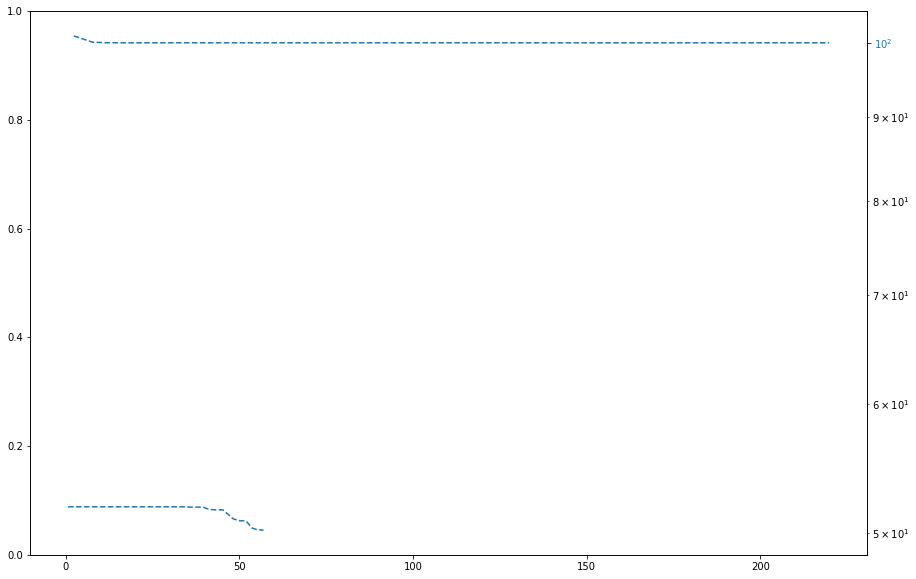

In [733]:
times = logging["time"]
times_notears = log_dict_notears["time"]
values_l2error = logging["l2_error"]
values_l2error_notears = log_dict_notears["l2_error"] - n
l2error_notears = 1/1000*np.linalg.norm(X@(np.eye(n)-W_notears))**2
l2error_ours = 1/1000*np.linalg.norm(X@(np.eye(n)-Wk))**2
l2error_opt = 1/1000*np.linalg.norm(X@(np.eye(n)-w_opt))**2
values_l1pen = logging["l1_val"] 
values_l1pen_notears = log_dict_notears["l1_val"] 
l1pen_notears = np.sum(np.abs(W_notears))
l1pen_ours = np.sum(np.abs(Wk))
l1pen_opt = np.sum(np.abs(w_opt))
values_dagness = logging["dag_constraint"]
values_dagness_notears = log_dict_notears["dag_constraint"] + n
dagness_notears = np.trace(np.linalg.matrix_power(np.eye(n) + logging["dagness_exp"] * np.abs(W_notears), n))
dagness_ours = np.trace(np.linalg.matrix_power(np.eye(n) + logging["dagness_exp"] * np.abs(Wk), n))
dagness_opt = np.trace(np.linalg.matrix_power(np.eye(n) + logging["dagness_exp"] * np.abs(w_opt), n))
values_obj = values_l2error + logging["dagness_pen"] * values_dagness + logging["l1_pen"] * values_l1pen
values_obj_notears = values_l2error_notears + values_dagness_notears + log_dict_notears["l1_pen"] * values_l1pen_notears
obj_notears = l2error_notears + logging["dagness_pen"] * dagness_notears + logging["l1_pen"] * l1pen_notears
obj_ours = l2error_ours + logging["dagness_pen"] * dagness_ours + logging["l1_pen"] * l1pen_ours
obj_opt = l2error_opt + logging["dagness_pen"] * dagness_opt + logging["l1_pen"] * l1pen_opt
logging["obj"] = values_obj
values_change_support = logging["nb_change_support"]

hlines = False

fig, ax1 = plt.subplots(figsize=(15,10))

# color = 'tab:red'
# l1 = ax1.plot(values_l1pen, label = "Sparcity = $\|A\|_1$", color=color)
# ax1.plot(values_l1pen_notears, "--", color=color)
# if hlines:
#     ax1.hlines([l1pen_notears, l1pen_ours, l1pen_opt], 0, 100, 
#                colors=[color], linestyles=["dashed", "dashdot", "dotted"])
# ax1.tick_params(axis='y', labelcolor=color)
# ax1.set_yscale("log")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
l2 = ax2.plot(times, values_dagness, "--", label="DAGness = $\mathrm{Tr}((I+\\beta A)^n)$", color=color)
ax2.plot(times_notears, values_dagness_notears, "--", color=color)
if hlines:
    ax2.hlines([dagness_notears, dagness_ours, dagness_opt], 0, 100, 
               colors=[color], linestyles=["dashed", "dashdot", "dotted"])
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale("log")

# ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# color = 'tab:green'
# l3 = ax3.plot(values_l2error, color=color, label='$L_2\mathrm{\,error\,=\,}1/m||X (I-W)||^2$')
# ax3.plot(values_l2error_notears, "--", color=color)
# if hlines:
#     ax3.hlines([l2error_notears, l2error_ours, l2error_opt], 0, 100, 
#                colors=[color], linestyles=["dashed", "dashdot", "dotted"])
# ax3.tick_params(axis='y', labelcolor=color)
# ax3.set_yscale("log")

# ax4 = ax1.twinx()
# color = 'tab:grey'
# l4 = ax4.plot(values_obj, color=color, label='Objective = $f(x)+g(x)$')
# ax4.hlines([obj_notears, obj_ours, obj_opt], 0, 100, 
#            colors=['grey'], linestyles=["dashed", "dashdot", "dotted"])
# ax4.tick_params(axis='y', labelcolor=color)
# ax4.set_yscale("log")

# ax5 = ax1.twinx()
# color = 'tab:pink'
# l5 = ax5.plot(values_change_support, color=color, label='Number of changes in support')
# ax5.tick_params(axis='y', labelcolor=color)
# ax5.set_yscale("log")

lines = l1 + l2 + l3 #+ l4 # + l5
labs = [l.get_label() for l in lines]
ax1.legend(lines, labs, ncol=2,  bbox_to_anchor=(1, 1.4))

plt.title("$\mathrm{Ours}$ convergence");

In [ ]:
dagness_notears, dagness_ours, dagness_opt

The second one is a mere visualisation of the output as a heatmap.

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(w_opt, center=0, ax=axs[0]); axs[0].set_xticks([]);  axs[0].set_yticks([]); 
axs[0].set_title("Ground truth adjacency matrix");
sns.heatmap(Wk, center=0, ax=axs[1]); axs[1].set_xticks([]);  axs[1].set_yticks([]); 
axs[1].set_title("Output adjacency matrix");

The last one demonstrates the convergence of the matrix support with iterations, as we go down, our algorithm progresses towards the correct graph, the last line (light blue) being the ground truth adjacency matrix

In [ ]:
n_iter = len(logging["support"])
plt.figure(figsize=(18,5))
sns.heatmap(np.array(np.append(np.int32(logging["support"]),
                               -np.reshape(adj_matrix.flatten(), (1,n*n)), axis=0)),
           center=0, cbar=False); 
plt.xticks([]); plt.yticks(np.arange(0, n_iter+1, step=n_iter//10), np.arange(0, n_iter+1, step=n_iter//10));
plt.xlim([0, 500])
plt.title("Convergence of the support")
plt.xlabel("Coefficients of matrix 0 to 500");
plt.ylabel("Number of iterations");

Thank you!